In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1) 
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

# MNIST dataset

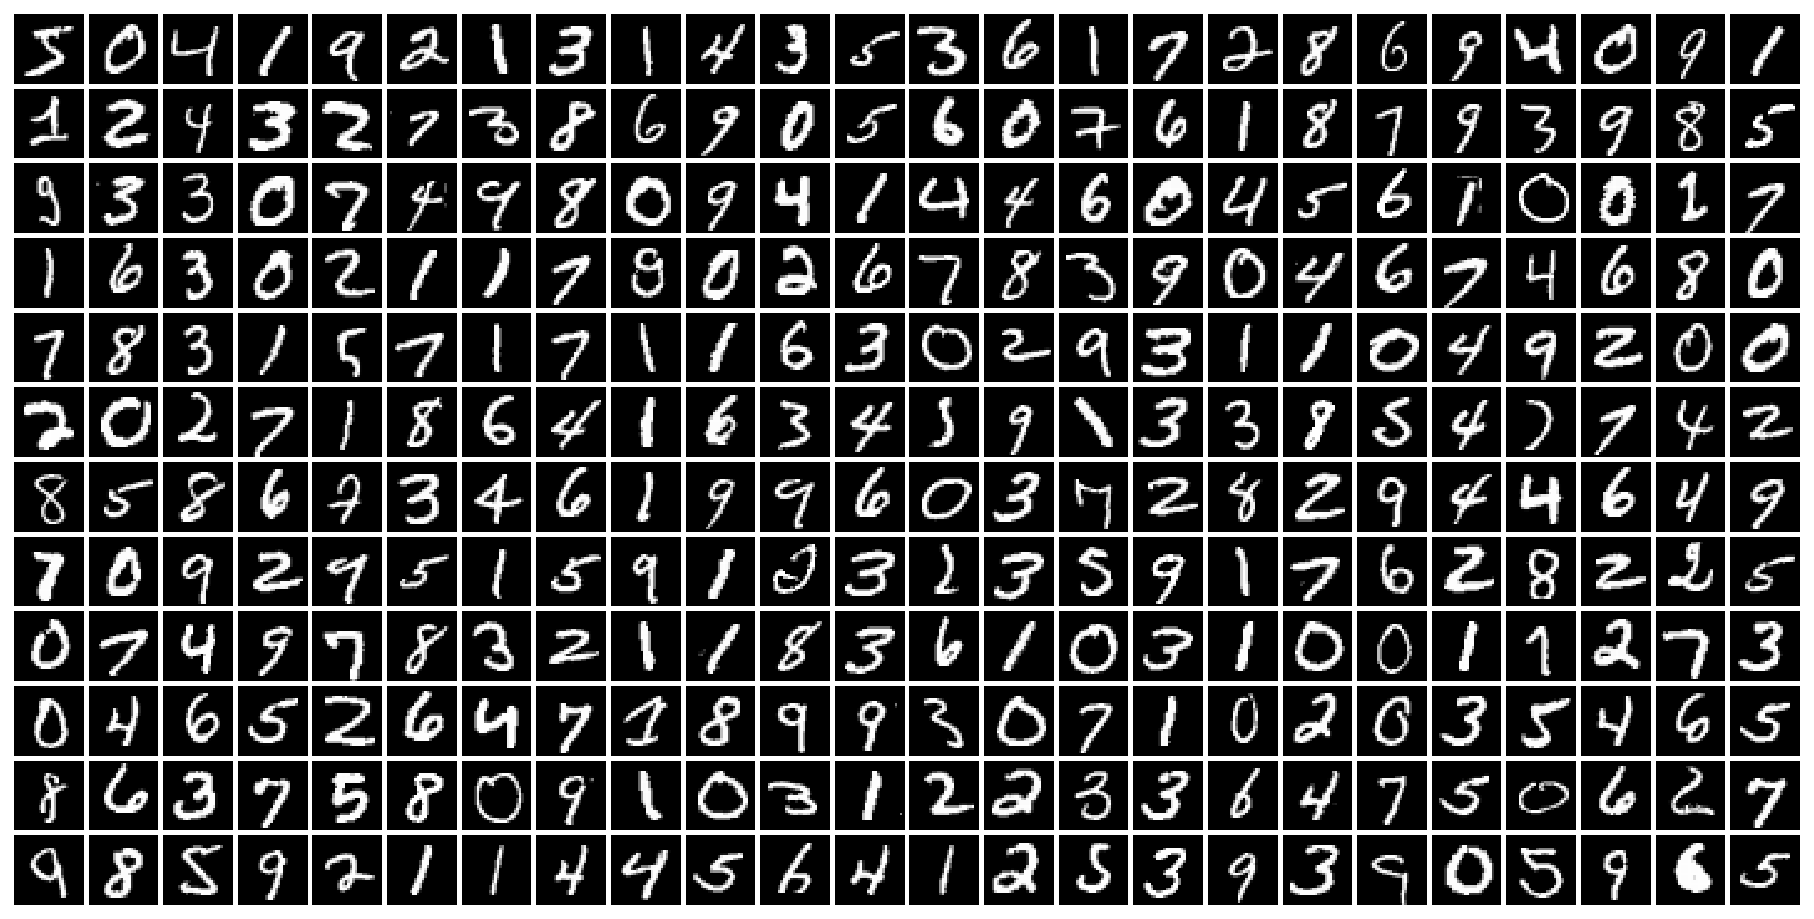

In [3]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Backpropagation algorithm

In [4]:
def sigmoid(batch):
    return 1.0 / (1.0 + np.exp(-batch))

def sigmoid_derivative(batch):
    s = sigmoid(batch)
    return s * (1.0 - s)

class Layer:
    def __init__(self, visible_size, hidden_size, activation_fun, d_activation_fun, learning_rate, momentum):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
                
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size)).astype(np.float32)
        self.W[-1, :] = 0.0
        
        self.activations = None
        self.d_activations = None
        self.deltas = None

        self.M = zeros(self.visible_size+1, self.hidden_size)

### Softmax activation

Implement the softmax activation function. Remember that naive sotmax implementation is numerically unstable: the numerator and the denominator may overflow. Make sure that your implementation has no overflow issues.

numerator - licznik <br>
denominator - mianownik

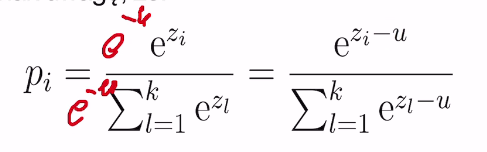

In [23]:
def softmax(batch):
    u = np.max(batch, axis=0)
    numerator = np.exp(batch - u)
    denominator = np.sum(numerator, axis=0) # Indeksy w mianowniku numerują klasy, nie przykłady uczące
                  # numerator.sum()
    return numerator / denominator

In [36]:
def softmax(batch):
    u = np.max(batch, axis=-1)
    numerator = np.exp(batch - u)
    denominator = np.sum(numerator, axis=-1, keepdims=True) # Indeksy w mianowniku numerują klasy, nie przykłady uczące
                  # numerator.sum()
    return numerator / denominator

In [37]:
softmax(np.array([1, 2, 3, 4, 5]))

array([0.01165623, 0.03168492, 0.08612854, 0.23412166, 0.63640865])

### Forward pass

Calculate the total input to the neurons. Then calculate the activations (remember to add *ones* as the last column). Store the result in `layer.activations`.

##### Computing derivatives of activation function

If `compute_derivatives` is set to `True`, we also need to compute the derivatives of the activation function and store them in `layer.d_activations`. We **do not** need to add *ones column* to the derivatives matrix! *Ones* are only needed in the activations matrix, where they are used to add biases to the total input of neurons in the next hidden layer.


In [26]:
def forward_pass(mlp, batch, compute_derivatives):
    visible = batch
    
    for layer_idx, layer in enumerate(mlp):
        # Część 1. Wyznaczenie aktywacji sieci.
        preactivation_z = visible @ layer.W
        activation = layer.activation_fun(preactivation_z)
        layer.activations = append_ones(activation)

        
        # Część 2. Wyznaczenie pochodnych aktywacji sieci.
        if compute_derivatives and (layer_idx < len(mlp) - 1):
            layer.d_activations = layer.d_activation_fun(preactivation_z)
        
        visible = layer.activations
        
    return visible[:, :-1]

### Error backpropagation

Fist, we need to calculate the deltas in `prev_layer`. To calculate them we use:
 - deltas and weights from `layer`,
 - derivatives of the activation function from `prev_layer`.
 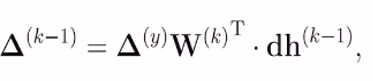
 
Once *deltas* are calculated, we can use them to compute gradients.

gradient:
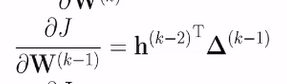

In [27]:
def error_backpropagate(mlp, batch):
    observations_count = batch.shape[0]
    
    for layer_idx, layer in reversed(list(enumerate(mlp))):
        if layer_idx > 0:
            prev_layer = mlp[layer_idx - 1]
            visible = prev_layer.activations

            prev_layer.deltas = (layer.deltas @ layer.W[:-1].T) * prev_layer.d_activations
            # Transposition is needed. layer.W is adjusted to the "forward" direction.
        else:
            visible = batch
        
        
        gradient = (visible.T @ layer.deltas) / observations_count # Normalize because of batched SGD
        layer.M = layer.momentum * layer.M - layer.learning_rate * gradient
        layer.W += layer.M

### MLP training

In order to start the back propagation procedure, we need to compute *deltas* in the output layer (that is $\Delta^{\left(y\right)}$). Use network output (from the forward pass) and target labels (stored in `batch_labels`) to calculate the *deltas*. Remember that the output layer is a softmax and that we minimize cross-entropy cost.

In [28]:
def train_mlp(mlp, dataset, labels, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    
    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)
    
    for batch_idx, (batch, batch_labels) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        y = forward_pass(mlp, batch, True)
        
        mlp[-1].deltas = y - batch_labels
        
        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, batch)
        
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

# MNIST digits classification

In [29]:
def classify(mlp, batch):
    probabilities = forward_pass(mlp, batch, False)
    return np.argmax(probabilities, axis=1)

def run_training(mlp, train_set, train_labels,
                 validation_set, validation_labels,
                 batch_size, epochs_count):
    
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")

        start_time = time.time()
        train_mlp(mlp, train_set, train_labels, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, validation_set)
        accuracy = 100.0 * np.sum(predictions == validation_labels) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2f}".format(elapsed, accuracy))

    print("Training finished!")

In [30]:
def draw_layer_filters(layer):
    filters = np.reshape(layer.W[:-1, :].T, newshape=(8, -1, 28, 28))
    tiles(filters)

In [31]:
import time

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 256

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(mnist_test_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))
mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

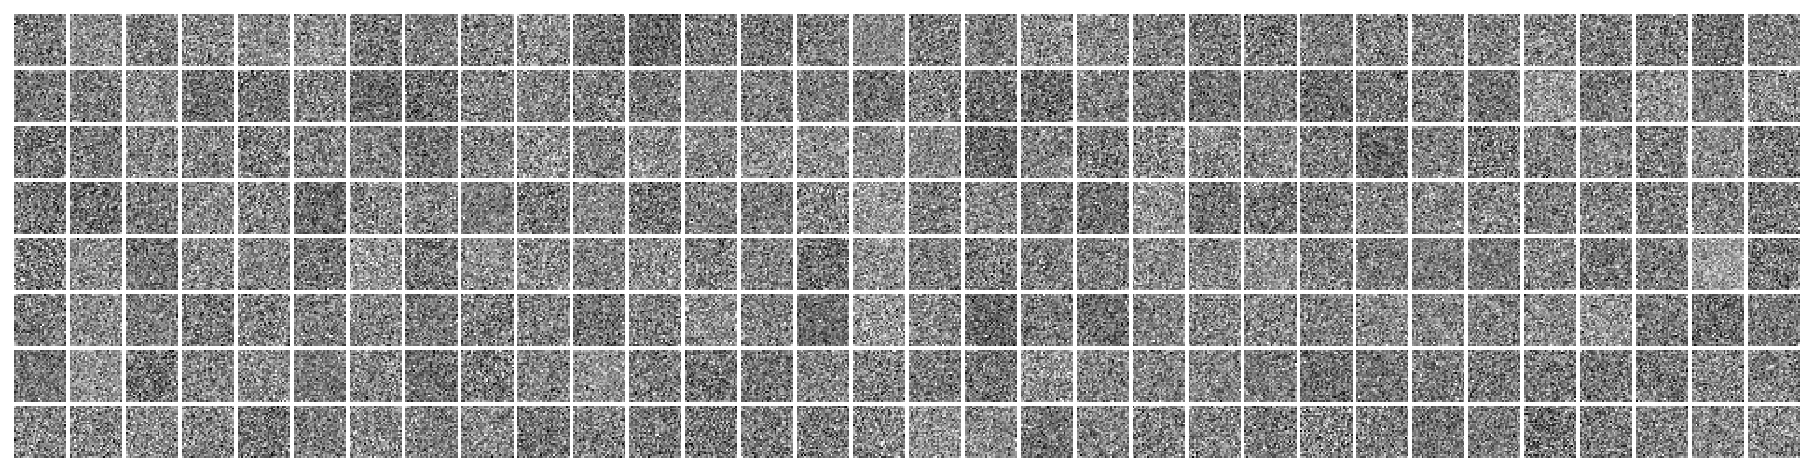

Epoch 1:	#####################################################	elapsed: 0.97s, accuracy: 21.03
Epoch 2:	#####################################################	elapsed: 0.90s, accuracy: 32.57
Epoch 3:	#####################################################	elapsed: 0.91s, accuracy: 36.35
Epoch 4:	#####################################################	elapsed: 0.85s, accuracy: 47.45
Epoch 5:	#####################################################	elapsed: 0.84s, accuracy: 66.89
Epoch 6:	#####################################################	elapsed: 0.88s, accuracy: 83.98
Epoch 7:	#####################################################	elapsed: 0.88s, accuracy: 88.85
Epoch 8:	#####################################################	elapsed: 0.92s, accuracy: 90.16
Epoch 9:	#####################################################	elapsed: 0.89s, accuracy: 90.92
Epoch 10:	#####################################################	elapsed: 0.89s, accuracy: 91.54
Epoch 11:	#######################################

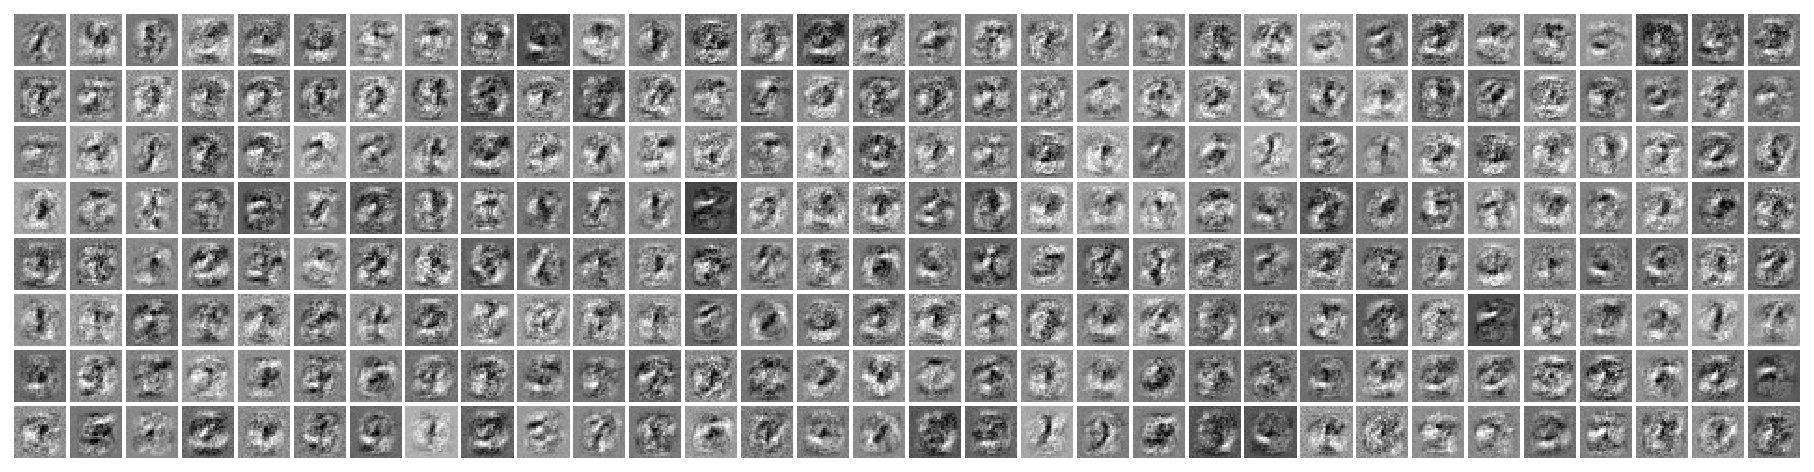

In [38]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
SOFTMAX_LEARNING_RATE = 0.15
MOMENTUM = 0.9

mlp = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, sigmoid_derivative, LEARNING_RATE, MOMENTUM),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, sigmoid_derivative, LEARNING_RATE, MOMENTUM),
    Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, SOFTMAX_LEARNING_RATE, MOMENTUM)
]

draw_layer_filters(mlp[0])

run_training(mlp,
             mnist_train_images, mnist_train_labels,
             mnist_test_images, mnist_test_labels,
             BATCH_SIZE, EPOCHS_COUNT)

draw_layer_filters(mlp[0])